In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table as ApTable

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
# Load the data
_images = np.load("../data/test_sim/images_3.npz")
images = _images["images"]
# Don't forget to make sure that the images has odd columns and rows
images = deblender.nmf.reshape_img(images)
filters = _images["filters"]
_psfs = np.load("../data/test_sim/psfs.npz")
psfs = _psfs["psfs"]
if np.all(_psfs["filters"]!=filters):
    raise Exception("PSF and image filters do not match")
catalog = ApTable.read("../data/test_sim/true_catalog_3.fits")

In [3]:
_peaks = np.array([np.array(catalog["x"]), np.array(catalog["y"])]).T
# For now, only use a single component for each object
src_list = np.unique(catalog["index"])
peaks = np.zeros((len(src_list), 2))
for sid in src_list:
    src = catalog[catalog["index"]==sid][0]
    peaks[sid] = [src["x"], src["y"]]

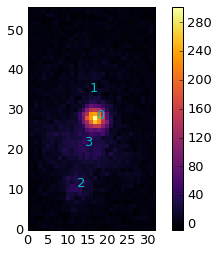

In [4]:
plt.imshow(images[0])
plt.colorbar()
for n, (px,py) in enumerate(peaks):
    plt.text(px, py, str(n), color='c')
plt.xlim([0,images[0].shape[1]-1])
plt.ylim([0, images[0].shape[0]-1])
plt.show()

In [6]:
result = deblender.nmf.deblend(
    images,
    peaks=peaks,
    constraints=["MS"]*len(peaks),
    psf=None,
    max_iter=100,
    e_rel=1e-2,
    l0_thresh=5e-4,
    traceback=True,
)

INFO:proxmin.algorithms:Completed 101 iterations


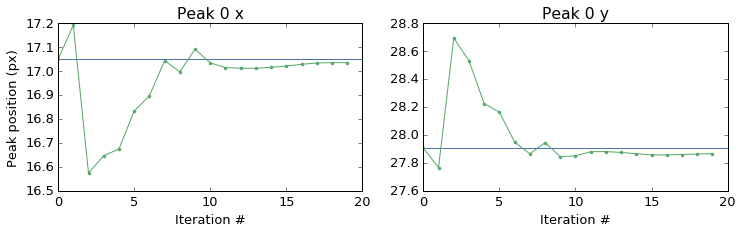

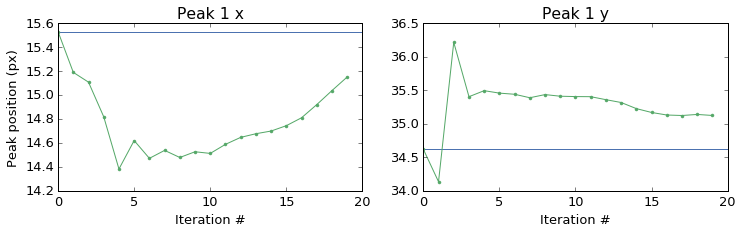

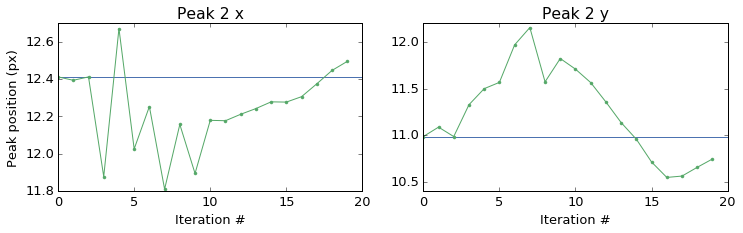

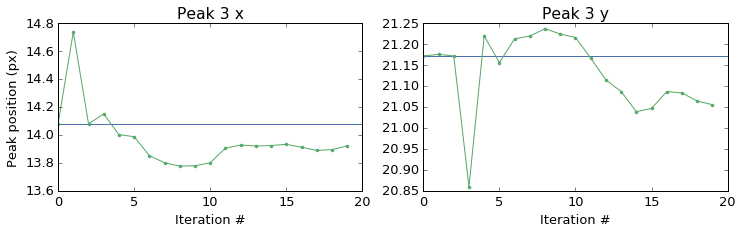

In [7]:
px_hist, py_hist = result.T.get_history()
model = result.get_model(combine=True)
img_shape = result.shape
cx, cy = int(img_shape[1]/2), int(img_shape[0]/2)
for k in range(len(peaks)):
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot([0,px_hist.shape[0]],[peaks[k][0],peaks[k][0]])
    ax1.plot(cx-px_hist[:,k], '.-')
    ax1.set_title("Peak {0} x".format(k))
    ax1.set_xlabel("Iteration #")
    ax1.set_ylabel("Peak position (px)")
    ax2.plot([0,py_hist.shape[0]],[peaks[k][1],peaks[k][1]])
    ax2.plot(cy-py_hist[:,k], '.-')
    ax2.set_title("Peak {0} y".format(k))
    ax2.set_xlabel("Iteration #")
    plt.show()

In [14]:
e_rel = 1e-2
e_abs = 1e-2
Ls = result.parameters["Ls"]
Ahist = result.get_history("A")
Shist = result.get_history("S")
e_A = np.array([list(proxmin.utils.get_variable_errors(Ahist["X"][0][i],
                                                       Ls[0][0],
                                                       Ahist["X"][0][i],
                                                       Ahist["Z"][0][i],
                                                       Ahist["U"][0][i],
                                                       Ahist["steps_g"][0][i],
                                                       e_rel,
                                                       e_abs))
                for i in range(1,len(Ahist["X"][0]))])
e_pri2A = e_A[:,0]
e_dual2A = e_A[:,1]

s_vars = ["Monotonicity", "Symmetry"]
e_priS = {}
e_dualS = {}
for j,L in enumerate(Ls[1]):
    e_S = np.array([list(proxmin.utils.get_variable_errors(Shist["X"][0][i],
                                                       L,
                                                       L.dot(Shist["X"][0][i]),
                                                       Shist["Z"][j][i],
                                                       Shist["U"][j][i],
                                                       Shist["steps_g"][j][i],
                                                       e_rel,
                                                       e_abs))
                for i in range(1,len(Shist["X"][0]))])
    e_priS[s_vars[j]] = e_S[:,0]
    e_dualS[s_vars[j]] = e_S[:,1]

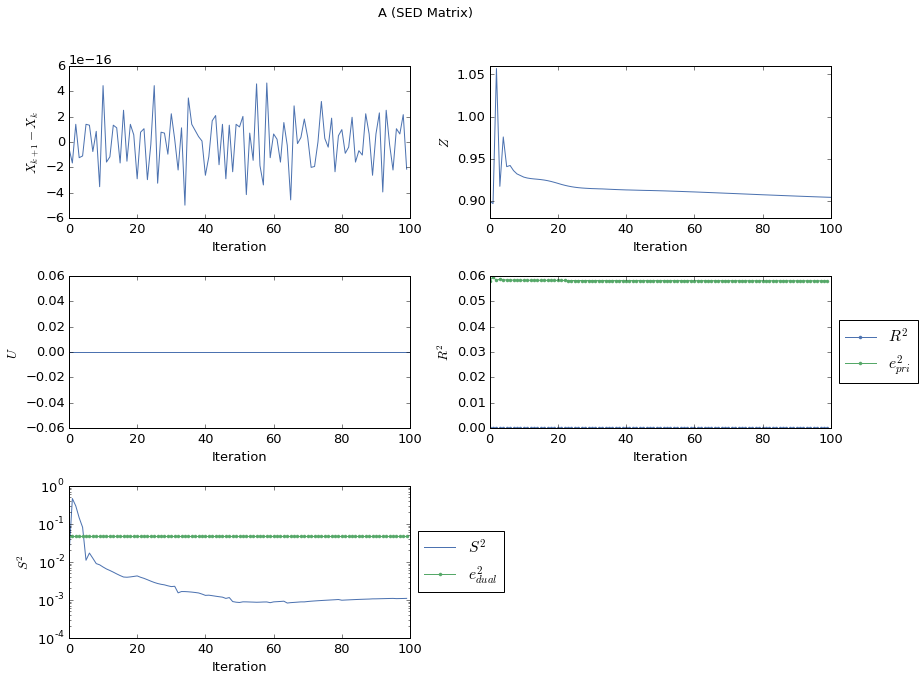

In [15]:
def l2hist(X):
    return np.sqrt(np.sum(X**2, axis=(1,2)))

fig = plt.figure(figsize=(12,9))
ax = [fig.add_subplot(3,2,n+1) for n in range(5)]
fig.suptitle("A (SED Matrix)", y=1.05)

ax[0].plot(np.sum((Ahist["X"][0][1:]-Ahist["X"][0][:-1]), axis=(1,2)))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$X_{{k+1}}-X_k$")

ax[1].plot(l2hist(Ahist["Z"][0]))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(l2hist(Ahist["U"][0]))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

ax[3].plot(l2hist(Ahist["R"][0][1:]), '.-', label="$R^2$")
ax[3].plot(e_pri2A, '.-', label="$e_{{pri}}^2$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("$R^2$")

ax[4].semilogy(l2hist(Ahist["S"][0][1:]), label="$S^2$")
ax[4].plot(e_dual2A, '.-', label="$e_{{dual}}^2$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")
ax[4].set_ylabel("$S^2$")

plt.tight_layout()
plt.show()

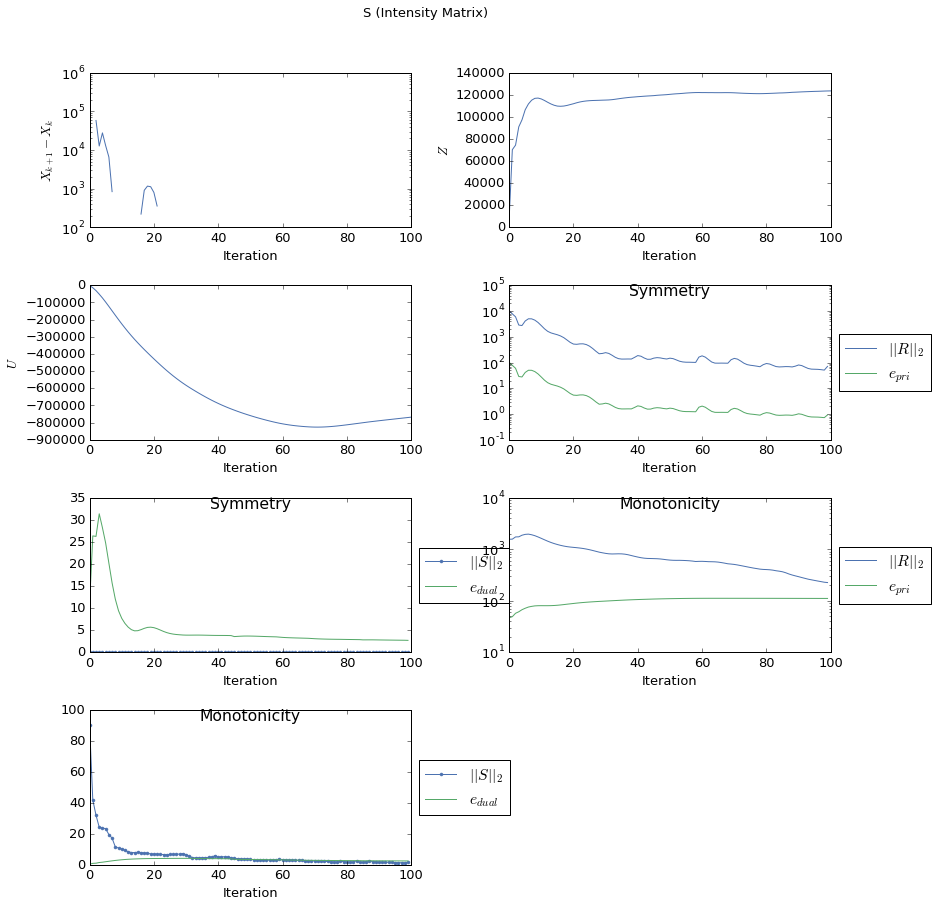

In [16]:
fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(4,2,n+1) for n in range(7)]
fig.suptitle("S (Intensity Matrix)", y=1.05)

dS = Shist["X"][0][1:]-Shist["X"][0][:-1]
ax[0].semilogy(np.sum(dS, axis=(1,2)))
#ax[0].plot(np.sum(np.abs((Shist["X"][0][1:]-Shist["X"][0][:-1])), axis=(1,2)))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$X_{{k+1}}-X_k$")

ax[1].plot(np.sum(Shist["Z"][0], axis=(1,2)))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(np.sum(Shist["U"][0], axis=(1,2)))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

ax[3].semilogy(l2hist(Shist["R"][1][1:]), label="$||R||_2$")
ax[3].plot(e_priS["Symmetry"], label="$e_{pri}$")
#ax[3].plot([0,len(Shist["X"][0])-1],[e_rel,e_rel], label="$e_{rel}$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")
ax[3].set_title("Symmetry", y=0.9)

ax[4].plot(l2hist(Shist["S"][1][1:]), '.-', label="$||S||_2$")
ax[4].plot(e_dualS["Symmetry"], label="$e_{dual}$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")
ax[4].set_title("Symmetry", y=0.9)

ax[5].semilogy(l2hist(Shist["R"][0][1:]), label="$||R||_2$")
ax[5].plot(e_priS["Monotonicity"], label="$e_{pri}$")
#ax[5].plot([0,len(Shist["X"][0])-1],[e_rel,e_rel], label="$e_{rel}$")
ax[5].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[5].set_xlabel("Iteration")
ax[5].set_title("Monotonicity", y=0.9)

ax[6].plot(l2hist(Shist["S"][0][1:]), '.-', label="$||S||_2$")
ax[6].plot(e_dualS["Monotonicity"], label="$e_{dual}$")
ax[6].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[6].set_xlabel("Iteration")
ax[6].set_title("Monotonicity", y=0.9)

plt.tight_layout()
plt.show()